In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

%matplotlib inline

In [2]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "dataset")
filename_data = os.path.join(path_data, "weather_prediction_dataset.csv")

In [3]:
data = pd.read_csv(filename_data)
data.head()


,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [5]:
list({x.split("_")[0] for x in data.columns if x not in ["MONTH", "DATE"]})

['DE',
 'MALMO',
 'HEATHROW',
 'TOURS',
 'BUDAPEST',
 'DRESDEN',
 'OSLO',
 'MAASTRICHT',
 'MONTELIMAR',
 'DUSSELDORF',
 'KASSEL',
 'ROMA',
 'PERPIGNAN',
 'SONNBLICK',
 'STOCKHOLM',
 'MUENCHEN',
 'BASEL',
 'LJUBLJANA']

In [6]:
X_data = data.loc[:(data.shape[0]-2)].drop(columns=['DATE', 'MONTH'])
y_data = data.loc[1:]["ROMA_temp_max"]

predicted_labelname = "predicted max.temperature"
true_labelname = "true max.temperature"

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [8]:
y_train[:10]

746      5.0
3188    22.6
1982    26.4
3396    16.2
2683    22.0
848     21.0
3328    13.0
1255    32.8
3618    17.2
3082    24.6
Name: ROMA_temp_max, dtype: float64

In [9]:
y_train.max(), y_train.min()


(40.0, 1.8)

In [10]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Model

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 163)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 163)                 │             652 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,623 (88.37 KB)

 Trainable params: 22,297 (87.10 KB)

 Non-trainable params: 326 (1.27 KB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 1s - 15ms/step - loss: 459.1689 - root_mean_squared_error: 21.4282 - val_loss: 303.5115 - val_root_mean_squared_error: 17.4216
Epoch 2/1000
80/80 - 0s - 1ms/step - loss: 333.3330 - root_mean_squared_error: 18.2574 - val_loss: 194.4970 - val_root_mean_squared_error: 13.9462
Epoch 3/1000
80/80 - 0s - 1ms/step - loss: 178.6114 - root_mean_squared_error: 13.3646 - val_loss: 109.1861 - val_root_mean_squared_error: 10.4492
Epoch 4/1000
80/80 - 0s - 1ms/step - loss: 106.5407 - root_mean_squared_error: 10.3219 - val_loss: 78.5250 - val_root_mean_squared_error: 8.8614
Epoch 5/1000
80/80 - 0s - 1ms/step - loss: 80.9756 - root_mean_squared_error: 8.9986 - val_loss: 63.3535 - val_root_mean_squared_error: 7.9595
Epoch 6/1000
80/80 - 0s - 1ms/step - loss: 70.7385 - root_mean_squared_error: 8.4106 - val_loss: 53.0180 - val_root_mean_squared_error: 7.2813
Epoch 7/1000
80/80 - 0s - 1ms/step - loss: 60.5002 - root_mean_squared_error: 7.7782 - val_loss: 43.3393 - val_root_mean_square

80/80 - 0s - 1ms/step - loss: 14.1897 - root_mean_squared_error: 3.7669 - val_loss: 8.2312 - val_root_mean_squared_error: 2.8690
Epoch 59/1000
80/80 - 0s - 1ms/step - loss: 13.3989 - root_mean_squared_error: 3.6605 - val_loss: 8.2736 - val_root_mean_squared_error: 2.8764
Epoch 60/1000
80/80 - 0s - 1ms/step - loss: 14.2641 - root_mean_squared_error: 3.7768 - val_loss: 8.3147 - val_root_mean_squared_error: 2.8835
Epoch 61/1000
80/80 - 0s - 1ms/step - loss: 13.5064 - root_mean_squared_error: 3.6751 - val_loss: 8.1189 - val_root_mean_squared_error: 2.8494
Epoch 62/1000
80/80 - 0s - 1ms/step - loss: 14.3793 - root_mean_squared_error: 3.7920 - val_loss: 9.4167 - val_root_mean_squared_error: 3.0687
Epoch 63/1000
80/80 - 0s - 1ms/step - loss: 13.1556 - root_mean_squared_error: 3.6271 - val_loss: 8.0367 - val_root_mean_squared_error: 2.8349
Epoch 64/1000
80/80 - 0s - 1ms/step - loss: 13.9285 - root_mean_squared_error: 3.7321 - val_loss: 8.0307 - val_root_mean_squared_error: 2.8339
Epoch 65/1000

Epoch 116/1000
80/80 - 0s - 1ms/step - loss: 11.0813 - root_mean_squared_error: 3.3289 - val_loss: 7.4095 - val_root_mean_squared_error: 2.7220
Epoch 117/1000
80/80 - 0s - 1ms/step - loss: 10.9910 - root_mean_squared_error: 3.3153 - val_loss: 7.9223 - val_root_mean_squared_error: 2.8147
Epoch 118/1000
80/80 - 0s - 1ms/step - loss: 10.7298 - root_mean_squared_error: 3.2756 - val_loss: 7.4524 - val_root_mean_squared_error: 2.7299
Epoch 119/1000
80/80 - 0s - 1ms/step - loss: 11.1103 - root_mean_squared_error: 3.3332 - val_loss: 7.7873 - val_root_mean_squared_error: 2.7906
Epoch 120/1000
80/80 - 0s - 1ms/step - loss: 10.5889 - root_mean_squared_error: 3.2541 - val_loss: 7.8808 - val_root_mean_squared_error: 2.8073
Epoch 121/1000
80/80 - 0s - 1ms/step - loss: 10.9781 - root_mean_squared_error: 3.3133 - val_loss: 7.4305 - val_root_mean_squared_error: 2.7259
Epoch 122/1000
80/80 - 0s - 1ms/step - loss: 10.5407 - root_mean_squared_error: 3.2466 - val_loss: 7.7069 - val_root_mean_squared_error:

80/80 - 0s - 1ms/step - loss: 9.3239 - root_mean_squared_error: 3.0535 - val_loss: 6.6816 - val_root_mean_squared_error: 2.5849
Epoch 174/1000
80/80 - 0s - 1ms/step - loss: 9.7355 - root_mean_squared_error: 3.1202 - val_loss: 6.8982 - val_root_mean_squared_error: 2.6264
Epoch 175/1000
80/80 - 0s - 1ms/step - loss: 10.2544 - root_mean_squared_error: 3.2023 - val_loss: 7.1511 - val_root_mean_squared_error: 2.6741
Epoch 176/1000
80/80 - 0s - 1ms/step - loss: 9.6349 - root_mean_squared_error: 3.1040 - val_loss: 6.7634 - val_root_mean_squared_error: 2.6007
Epoch 177/1000
80/80 - 0s - 1ms/step - loss: 9.9324 - root_mean_squared_error: 3.1516 - val_loss: 6.9687 - val_root_mean_squared_error: 2.6398
Epoch 178/1000
80/80 - 0s - 1ms/step - loss: 9.6576 - root_mean_squared_error: 3.1077 - val_loss: 6.7192 - val_root_mean_squared_error: 2.5921
Epoch 179/1000
80/80 - 0s - 1ms/step - loss: 9.7771 - root_mean_squared_error: 3.1268 - val_loss: 6.7280 - val_root_mean_squared_error: 2.5938
Epoch 180/100

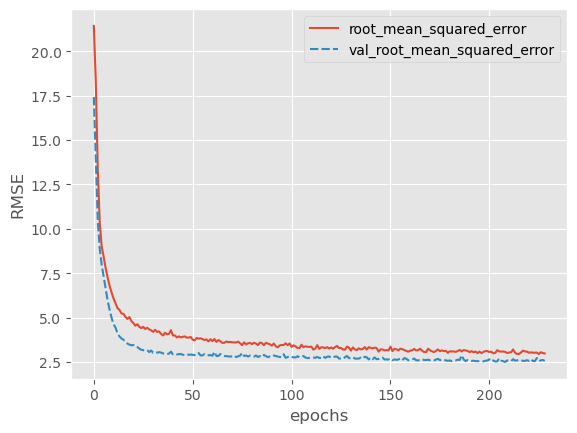

In [14]:
import seaborn as sns
plt.style.use('ggplot')
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.savefig("rmse_roma_plt.png", dpi=300)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


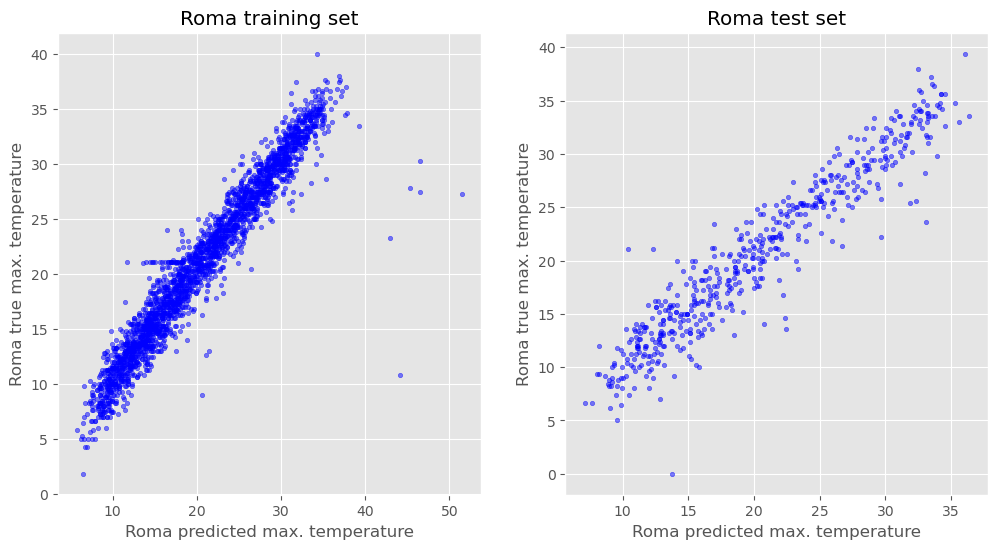

In [15]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="blue")
axes[0].set_title("Roma training set")
axes[0].set_xlabel("Roma predicted max. temperature")
axes[0].set_ylabel("Roma true max. temperature")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="blue")
axes[1].set_title("Roma test set")
axes[1].set_xlabel("Roma predicted max. temperature")
axes[1].set_ylabel("Roma true max. temperature")
plt.savefig("roma_max_temperature_plot.png", dpi=300)
